# Analysing an Optical System 

In [28]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import meep as mp
import scipy.optimize as sc
from meep_optics import OpticalSystem, AsphericLens, ApertureStop, ImagePlane, Sim, Analysis

Let's look at the analysis of an optical system, which is essentially made by looking at the far field beam of the system. For that, we propagate a gaussian source from the image plane to the aperture, then take the fourier transform of the field at the aperture.

We need to use a focused system, one is given here with 2 aspheric lenses with AR coating : 

In [3]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40, 
                     x = 130.+10., 
                     y = 0., 
                     AR_left = .5, AR_right = .5,
                     AR_delamination = 0.)
    
lens2 = AsphericLens(name = 'Lens 2', 
                     r1 = 269.190, 
                     r2 = 6398.02, 
                     c1 = -2.4029, 
                     c2 = 1770.36,
                     thick = 40, 
                     x = 40.+130.+369.408+10., 
                     y = 0.,
                     AR_left = .5, AR_right = .5,
                     AR_delamination = 0.)
    
aperture_stop = ApertureStop(name = 'Aperture Stop',
                             pos_x = 10,
                             diameter = 200,
                             thickness = 5,
                             n_refr = 1, 
                             conductivity = 100)
    
image_plane = ImagePlane(name = 'Image Plane',
                         pos_x = 10+714.704,
                         diameter = 300,
                         thickness = 2,
                         n_refr = 1.1, 
                         conductivity = 0.01)

We choose a wavelength of 10. The PML layer is fixed to half a wavelength.

In [86]:
wavelength = 2
res = 7
dpml = 5

Because the assembly process is always the same, let's wrap in a single function : 

In [5]:
def system_assembly(lens1, lens2, aperture_stop, image_plane, res, dpml):
    opt_sys = OpticalSystem('test')
    opt_sys.set_size(800,300)
    opt_sys.add_component(lens1)
    opt_sys.add_component(lens2)
    opt_sys.add_component(aperture_stop)
    opt_sys.add_component(image_plane)
    #print(opt_sys.list_components())
    
    
    opt_sys.assemble_system(dpml = dpml, resolution = res)
    opt_sys.write_h5file()
    
    return opt_sys

The wavelength in the lenses of index 1.52 (which is their default index) should be of about 2/1.52 = 1.3. To get at least 8 computational cells per wavelength, we can set the resolution to 1.

In [87]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = res, dpml = dpml)

Initialize the sim and the analysis :

In [88]:
sim = Sim(opt_sys)
analysis = Analysis(sim)

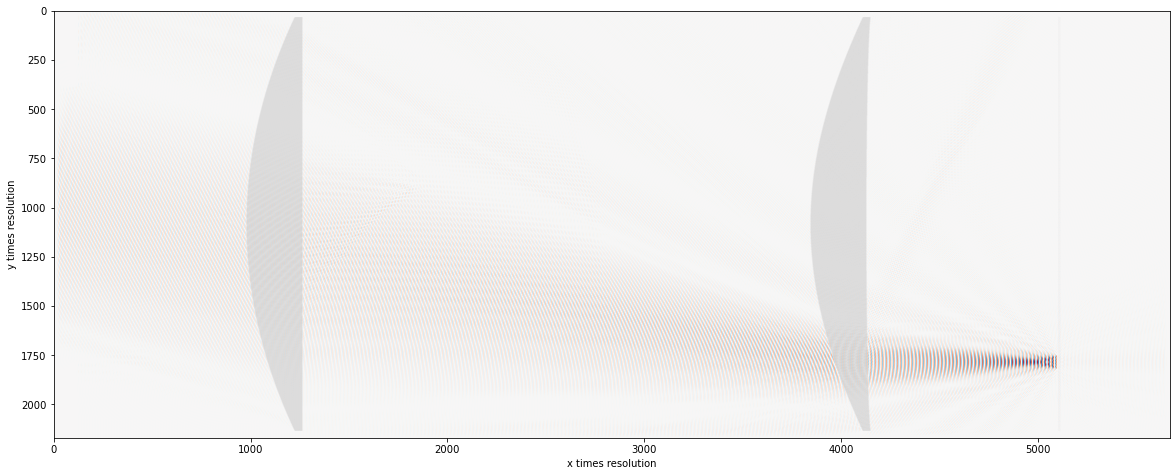

In [210]:
sim.define_source(wavelength = wavelength, sourcetype = 'Gaussian beam', 
                      x=754.704, y= 100, beam_width = 10, 
                      focus_pt_x= 0, focus_pt_y=0, size_x = 0, size_y=10)

sim.run_sim(runtime = 800, sim_resolution = res)
sim.plot_efield()

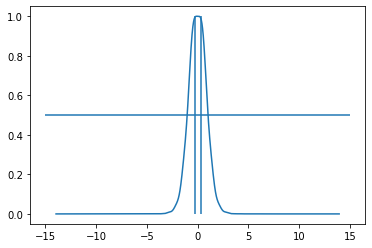

In [27]:
yaxis = np.linspace(-400,400,len(sim.oui))
degrees = np.arctan(yaxis/1610)*180/np.pi
sign = sim.oui/max(sim.oui)
plt.plot(degrees, sign)
plt.hlines(0.5, -15, 15)
plt.vlines([-2*180/(2*200*np.pi), 2*180/(2*200*np.pi)], 0, 1)

In [211]:
#fig = plt.figure(figsize = (10,10))
#ax = fig.add_subplot(projection='3d')

aper_pos_x = 10
efield = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
n_iter = 100
e_field_evol = np.ones((n_iter, len(efield)))
e_field_evol[0] = efield

#ax.plot(x, np.zeros(len(efield)), efield)
time = np.zeros(n_iter)
time[0] = sim.sim.meep_time()

timestep = wavelength/10
for k in range(n_iter):
    sim.sim.run(until = .3)
    time[k] = sim.sim.meep_time()
    efield_k = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
    #ax.plot(x, np.ones(len(efield))*k, efield_k)
    e_field_evol[k] = efield_k


#plt.show()
#plt.figure()
#plt.plot(np.arange(51), pouet)

1053.5714285714284


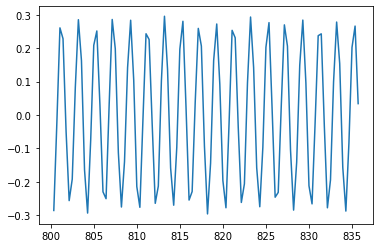

In [212]:
plt.plot(time, e_field_evol[:, 150*res])
plt.show()

In [213]:
def f(x, amp, phase):
    return amp*np.cos(x*2*np.pi/wavelength + phase)

t = np.arange(n_iter)*.3
popt, pcov = sc.curve_fit(f, time, e_field_evol[:,150*res])#, p0 = [np.mean(np.abs(e_field_evol[:,150*res])), 0])
print(popt)

[0.28542648 2.37223137]


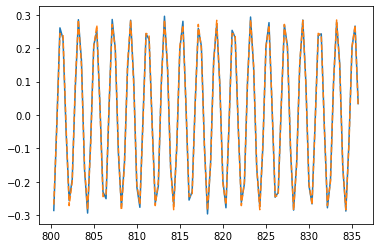

In [214]:
data = e_field_evol[:,150*res]
model = f(time, popt[0], popt[1])
plt.plot(time, data)
plt.plot(time, model, linestyle = '--')
plt.show()

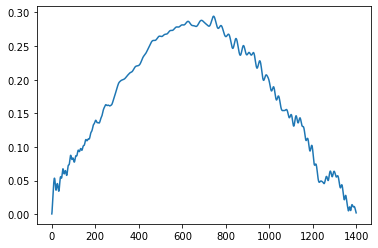

In [215]:
amplitude = np.zeros(200*res)
phase = np.zeros(200*res)
for k in range(200*res):
    popt, pcov = sc.curve_fit(f, time, e_field_evol[:,50*res+k])
    amplitude[k] = popt[0]
    phase[k] = popt[1]

plt.plot(np.arange(200*res), np.abs(amplitude))

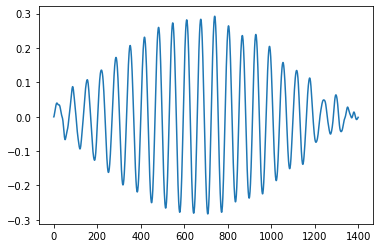

In [216]:
x = np.arange(200*res)
plt.plot(x, amplitude*np.cos(phase))

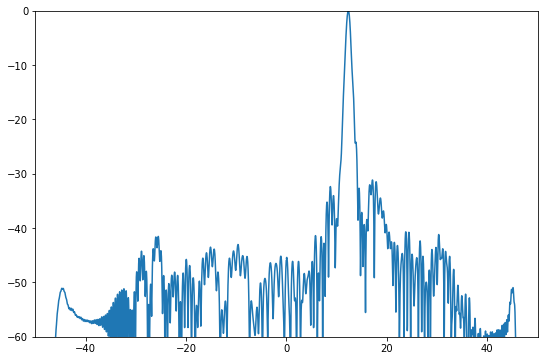

In [220]:
signal = amplitude*np.exp(1j*phase)

fft = np.fft.fft(signal, n = 15*len(signal))
freq = np.fft.fftfreq(15*len(signal), d = 1/res)

degrees = np.arctan(freq*wavelength)*180/np.pi

beam = fft*np.conj(fft)*(1+(freq*wavelength)**2)
fft_dB = 10*np.log10(np.abs(beam.real/np.max(beam.real)))

plt.figure(figsize = (9,6))
plt.plot(degrees, fft_dB)
plt.xlim((-50,50))
plt.ylim((-60,0))
plt.show()

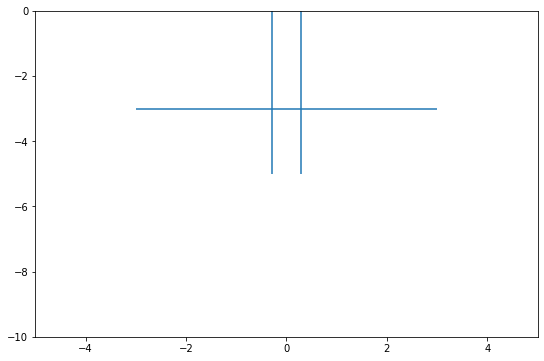

In [218]:
plt.figure(figsize = (9,6))
plt.plot(degrees, fft_dB)
plt.xlim((-5,5))
plt.ylim((-10,0))
plt.hlines(10*np.log10(.5), -3, 3)
plt.vlines([-wavelength*180/(2*200*np.pi), wavelength*180/(2*200*np.pi)], -5, 0)
plt.show()

Get the max e field

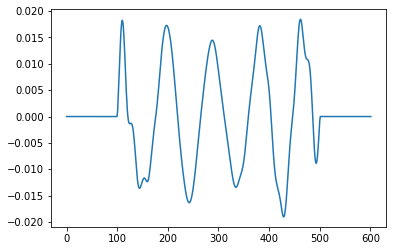

In [147]:
aper_pos_x = 10
efield = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
### Averaging
n_iter = 50
for k in range(n_iter):
    sim.sim.run(until = .5)
    efield += sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
        
field = efield/(n_iter+1)

plt.plot(np.arange(len(field)), field)
plt.show()

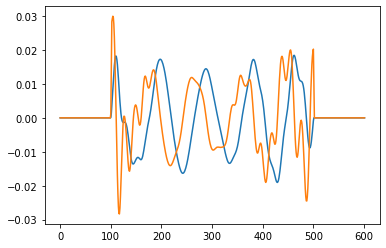

In [170]:
x = np.arange(len(field))
field2 = np.diff(field)
field2 = np.append(0, field2)
m = np.mean(np.abs(field))/np.mean(np.abs(field2))
field2 *= m
plt.plot(np.arange(len(field)), field)
plt.plot(np.arange(len(field)), field2)
#plt.xlim((900,1100))
#plt.ylim((-0.006,0.006))
plt.show() 

Let's quickly look at the FT of the averaged field :

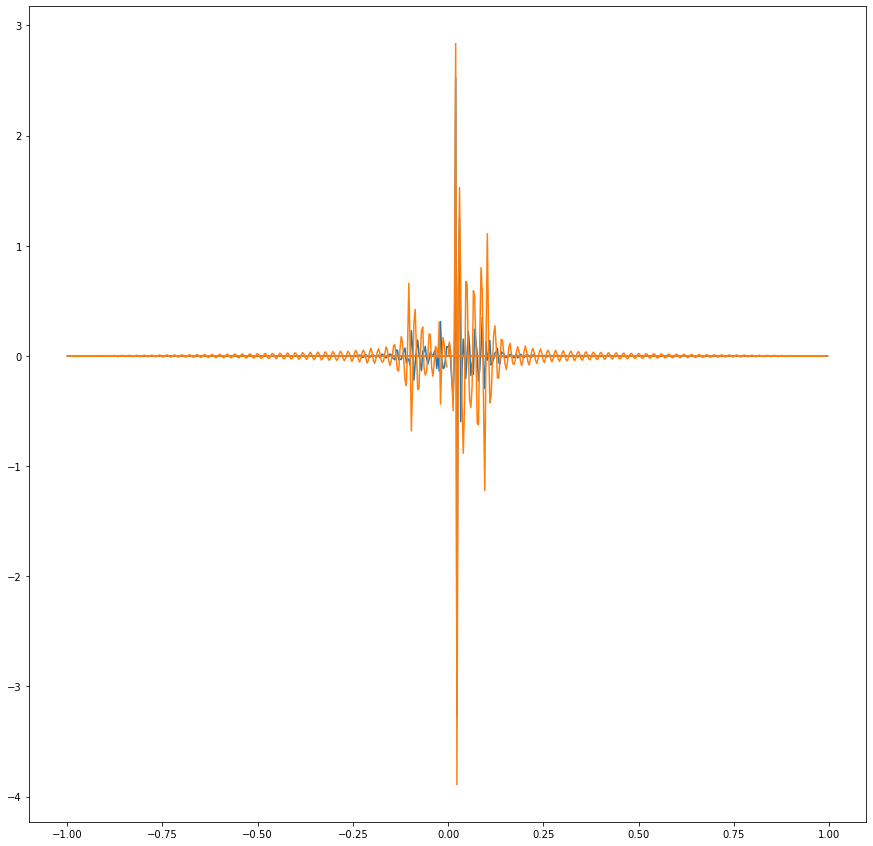

In [180]:
freq = np.fft.fftfreq(len(field), d = 1/res)
fft = np.fft.fft(field-1j*field2)
plt.figure(figsize = (15,15))
plt.plot(freq, fft.real, freq, fft.imag)
plt.show()

Let's zoom in :

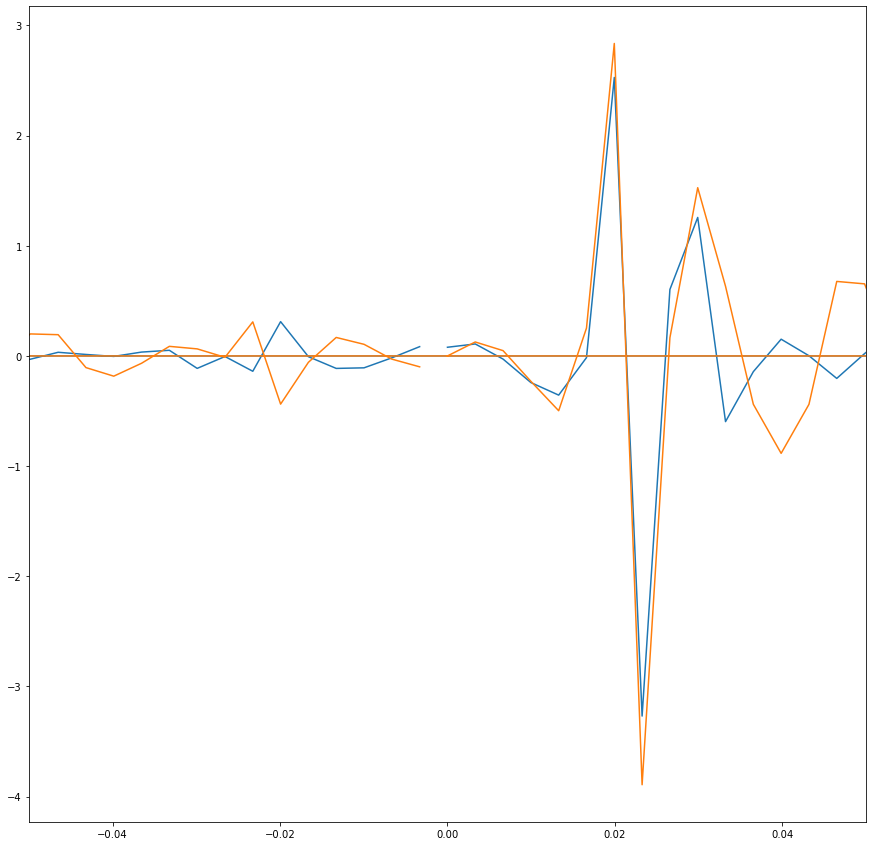

In [181]:
plt.figure(figsize = (15,15))
plt.plot(freq, fft.real, freq, fft.imag)
plt.xlim(-.05,.05)
plt.show()

Because the size of the sample is small compared to the size of the signal, the resolution is terrible. Let's extend the signal with zeros.

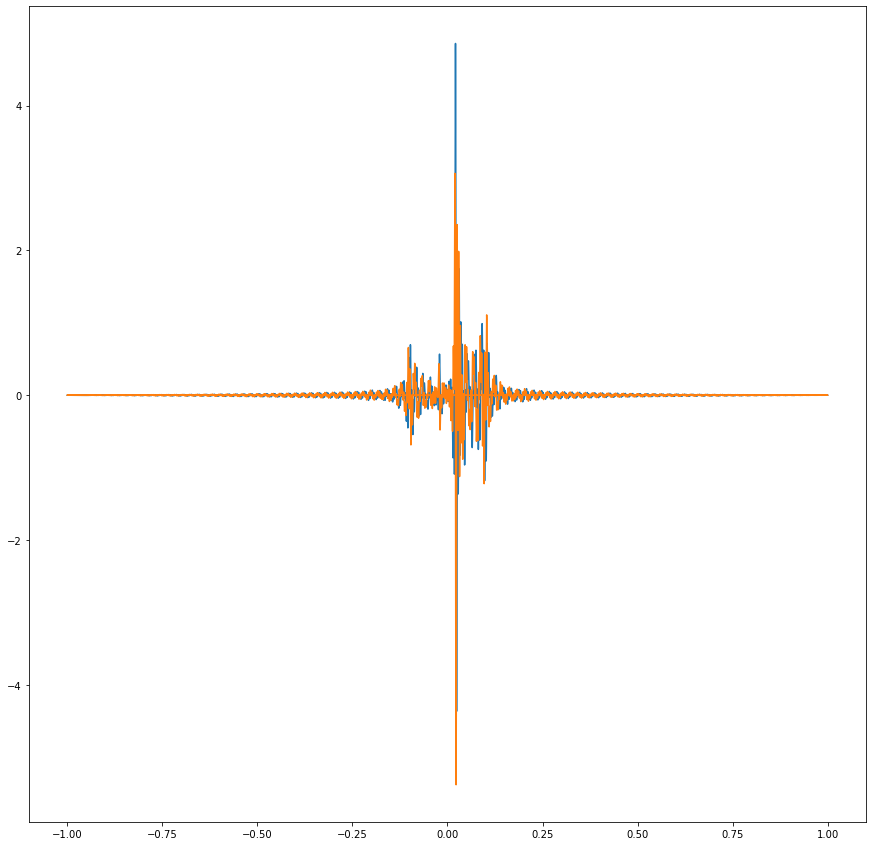

In [173]:
freq = np.fft.fftfreq(15*len(field), d = 1/res)
fft = np.fft.fft(field-1j*field2, n = 15*len(field))
plt.figure(figsize = (15,15))
plt.plot(freq, fft.real, freq, fft.imag)
plt.show()

And look at the FFT :

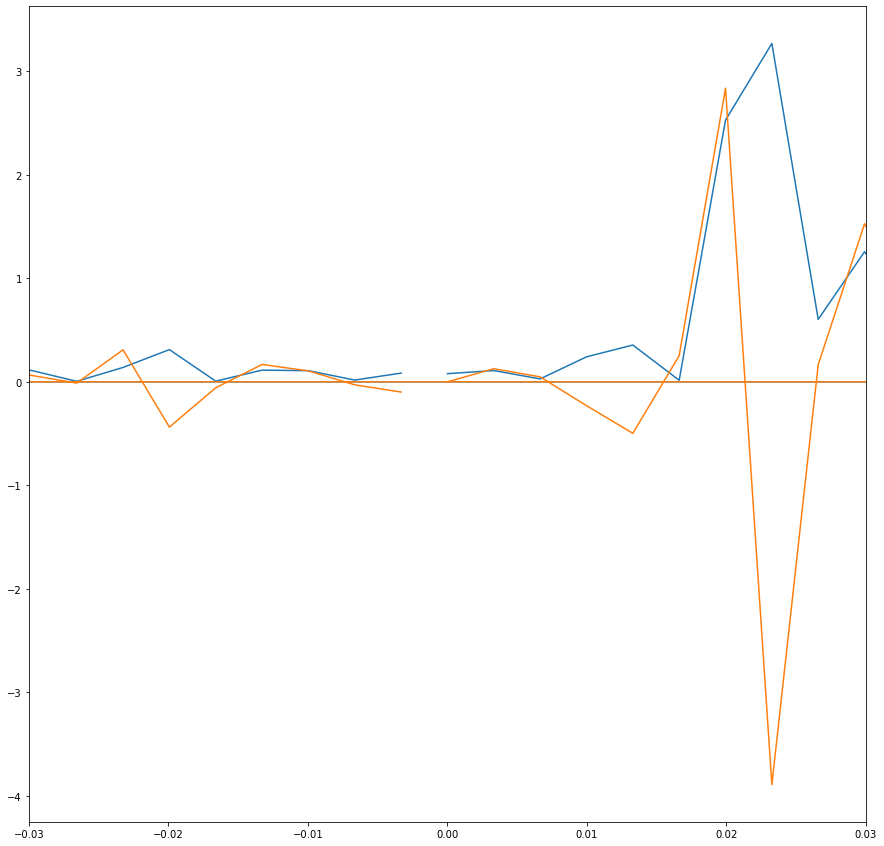

In [182]:
plt.figure(figsize = (15,15))
plt.plot(freq, np.abs(fft.real))
plt.plot(freq, fft.imag)
plt.xlim(-.03,.03)
plt.show()

It does look much better, now let's look at the same plot with the normalized FFT absolute value in dB:

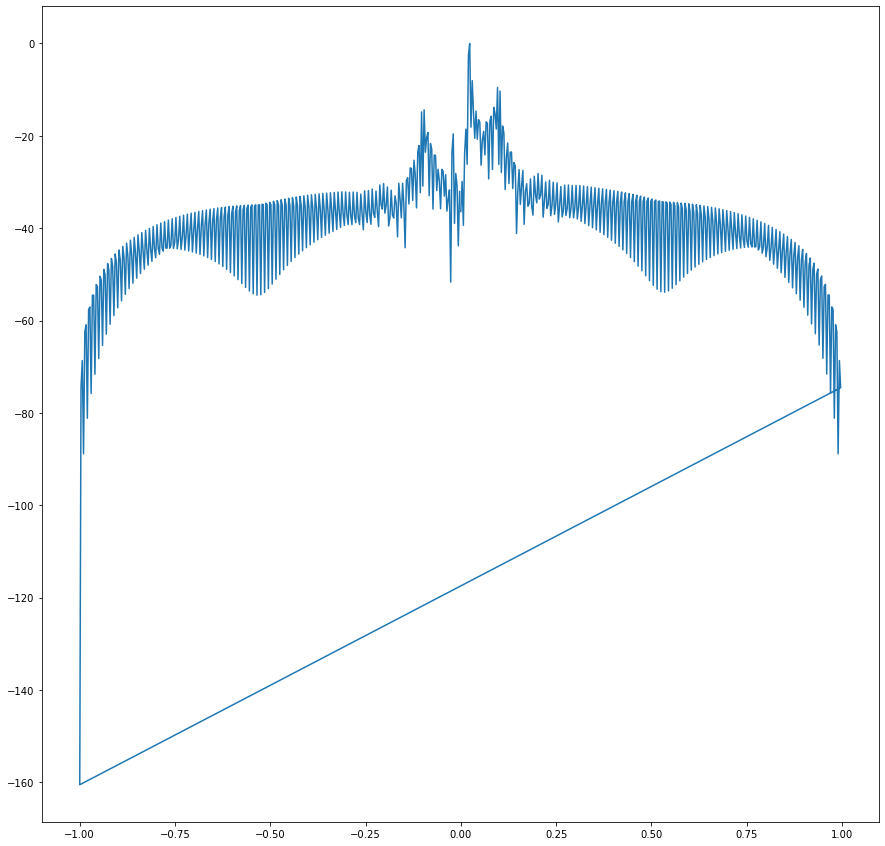

In [183]:
beam = fft*np.conj(fft)*(1+(freq*wavelength)**2)
fft_dB = 10*np.log10(np.abs(beam.real/np.max(beam.real)))
plt.figure(figsize = (15,15))
plt.plot(freq, fft_dB)
plt.show()

Let's get the x axis in degrees, with tan(theta)=wavelength x freq

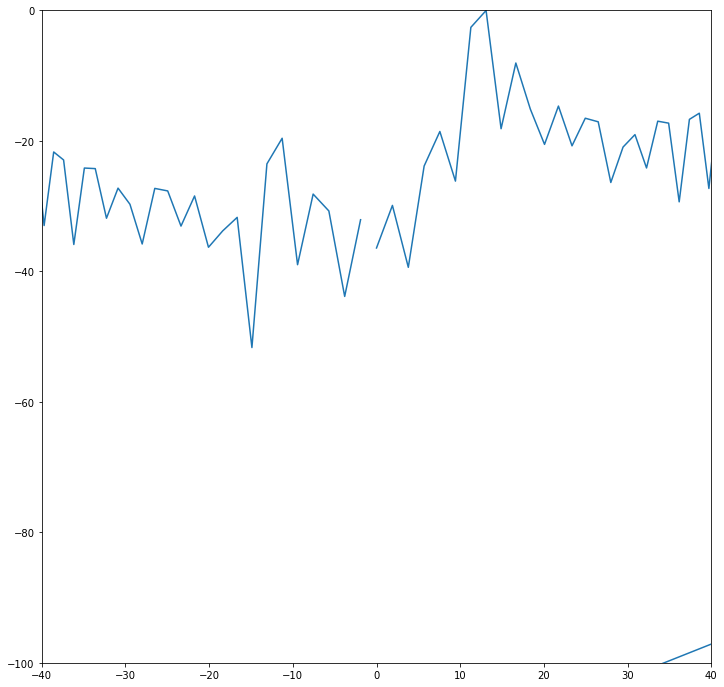

In [184]:
degrees = np.arctan(freq*wavelength)*180/np.pi
plt.figure(figsize = (12,12))
plt.plot(degrees, fft_dB)
plt.xlim((-40,40))
plt.ylim((-100, 0))
plt.show()

We can check the FWHM that we know is supposed to be $\frac{\lambda}{D} \cdot \frac{180}{\pi} = 2.864°$ 

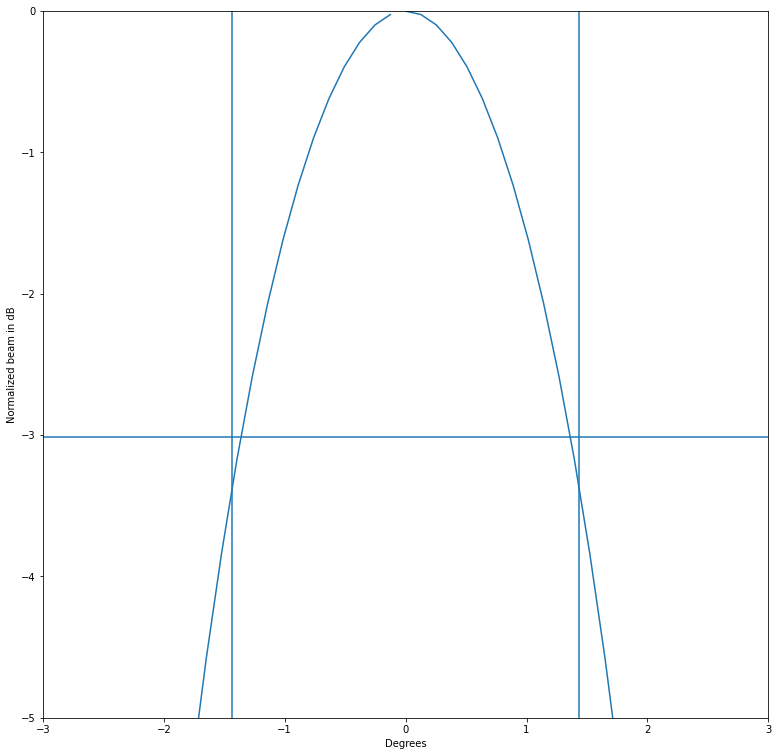

In [142]:
plt.figure(figsize = (13,13))
plt.plot(degrees, fft_dB)
plt.hlines(10*np.log10(.5), -3, 3)
plt.vlines([-wavelength*180/(2*200*np.pi), wavelength*180/(2*200*np.pi)], -5, 0)
plt.xlim((-3,3))
plt.ylim((-5, 0))
plt.xlabel('Degrees')
plt.ylabel('Normalized beam in dB')
plt.show()

Now let's test this with the analysis class provided in the code.

-----------
Initializing structure...
read in 5615x2115x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000883818 s
Working in 2D dimensions.
Computational cell is 802 x 302 x 0 with resolution 7
     block, center = (-350,125.5,0)
          size (5,51,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-350,-125.5,0)
          size (5,51,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (364.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
subpixel-averaging is 65.7914% done, 2.07988 s remaining
subpixel-averaging is 65.7999% done, 2.07925 s remaining
subpixel-averaging is 65.8084% done, 2.07845 s remaining
time for set_epsilon = 18.4707 s
time for set_conductivity = 0.728231 s
time for set_conductivity = 0.7

Meep progress: 169.92857142857142/800.0 = 21.2% done in 238.9s, 885.9s to go
on time step 2379 (time=169.929), 0.104027 s/step
Meep progress: 172.7142857142857/800.0 = 21.6% done in 243.0s, 882.4s to go
on time step 2418 (time=172.714), 0.103198 s/step
Meep progress: 175.5/800.0 = 21.9% done in 247.0s, 878.9s to go
on time step 2457 (time=175.5), 0.103268 s/step
Meep progress: 178.28571428571428/800.0 = 22.3% done in 251.0s, 875.3s to go
on time step 2496 (time=178.286), 0.103339 s/step
Meep progress: 181.07142857142856/800.0 = 22.6% done in 255.1s, 871.9s to go
on time step 2535 (time=181.071), 0.104235 s/step
Meep progress: 183.85714285714283/800.0 = 23.0% done in 259.1s, 868.4s to go
on time step 2574 (time=183.857), 0.103603 s/step
Meep progress: 186.64285714285714/800.0 = 23.3% done in 263.2s, 864.9s to go
on time step 2613 (time=186.643), 0.104353 s/step
Meep progress: 189.42857142857142/800.0 = 23.7% done in 267.3s, 861.4s to go
on time step 2652 (time=189.429), 0.10438 s/step
M

Meep progress: 350.85714285714283/800.0 = 43.9% done in 506.4s, 648.3s to go
on time step 4912 (time=350.857), 0.107469 s/step
Meep progress: 353.57142857142856/800.0 = 44.2% done in 510.5s, 644.6s to go
on time step 4950 (time=353.571), 0.107503 s/step
Meep progress: 356.2857142857143/800.0 = 44.5% done in 514.6s, 640.9s to go
on time step 4988 (time=356.286), 0.107919 s/step
Meep progress: 359.0/800.0 = 44.9% done in 518.7s, 637.2s to go
on time step 5026 (time=359), 0.107598 s/step
Meep progress: 361.7142857142857/800.0 = 45.2% done in 522.8s, 633.5s to go
on time step 5064 (time=361.714), 0.107709 s/step
Meep progress: 364.4285714285714/800.0 = 45.6% done in 526.9s, 629.7s to go
on time step 5102 (time=364.429), 0.107681 s/step
Meep progress: 367.1428571428571/800.0 = 45.9% done in 531.0s, 626.0s to go
on time step 5140 (time=367.143), 0.107804 s/step
Meep progress: 369.85714285714283/800.0 = 46.2% done in 535.1s, 622.3s to go
on time step 5178 (time=369.857), 0.107857 s/step
Meep 

Meep progress: 526.3571428571428/800.0 = 65.8% done in 773.6s, 402.2s to go
on time step 7369 (time=526.357), 0.11078 s/step
Meep progress: 529.0/800.0 = 66.1% done in 777.7s, 398.4s to go
on time step 7406 (time=529), 0.110876 s/step
Meep progress: 531.6428571428571/800.0 = 66.5% done in 781.8s, 394.6s to go
on time step 7443 (time=531.643), 0.110918 s/step
Meep progress: 534.2857142857142/800.0 = 66.8% done in 785.9s, 390.9s to go
on time step 7480 (time=534.286), 0.111049 s/step
Meep progress: 536.9285714285714/800.0 = 67.1% done in 790.0s, 387.1s to go
on time step 7517 (time=536.929), 0.110961 s/step
Meep progress: 539.5714285714286/800.0 = 67.4% done in 794.2s, 383.3s to go
on time step 7554 (time=539.571), 0.110968 s/step
Meep progress: 542.2142857142857/800.0 = 67.8% done in 798.3s, 379.5s to go
on time step 7591 (time=542.214), 0.110941 s/step
Meep progress: 544.8571428571428/800.0 = 68.1% done in 802.4s, 375.7s to go
on time step 7628 (time=544.857), 0.110968 s/step
Meep prog

Meep progress: 699.7857142857142/800.0 = 87.5% done in 1045.4s, 149.7s to go
on time step 9798 (time=699.857), 0.106819 s/step
Meep progress: 702.5/800.0 = 87.8% done in 1049.5s, 145.7s to go
on time step 9836 (time=702.571), 0.106464 s/step
Meep progress: 705.2142857142857/800.0 = 88.2% done in 1053.5s, 141.6s to go
on time step 9874 (time=705.286), 0.106468 s/step
Meep progress: 707.9285714285714/800.0 = 88.5% done in 1057.6s, 137.5s to go
on time step 9912 (time=708), 0.105867 s/step
Meep progress: 710.6428571428571/800.0 = 88.8% done in 1061.6s, 133.5s to go
on time step 9950 (time=710.714), 0.106471 s/step
Meep progress: 713.3571428571428/800.0 = 89.2% done in 1065.6s, 129.4s to go
on time step 9988 (time=713.429), 0.10548 s/step
Meep progress: 716.1428571428571/800.0 = 89.5% done in 1069.7s, 125.3s to go
on time step 10027 (time=716.214), 0.105125 s/step
Meep progress: 718.8571428571428/800.0 = 89.9% done in 1073.7s, 121.2s to go
on time step 10065 (time=718.929), 0.105564 s/step

run 65 finished at t = 832.5 (11655 timesteps)
run 66 finished at t = 833.0 (11662 timesteps)
run 67 finished at t = 833.5 (11669 timesteps)
run 68 finished at t = 834.0 (11676 timesteps)
run 69 finished at t = 834.5 (11683 timesteps)
on time step 11687 (time=834.786), 0.105701 s/step
run 70 finished at t = 835.0 (11690 timesteps)
run 71 finished at t = 835.5 (11697 timesteps)
run 72 finished at t = 836.0 (11704 timesteps)
run 73 finished at t = 836.5 (11711 timesteps)
run 74 finished at t = 837.0 (11718 timesteps)
run 75 finished at t = 837.5 (11725 timesteps)
on time step 11725 (time=837.5), 0.108061 s/step
run 76 finished at t = 838.0 (11732 timesteps)
run 77 finished at t = 838.5 (11739 timesteps)
run 78 finished at t = 839.0 (11746 timesteps)
run 79 finished at t = 839.5 (11753 timesteps)
run 80 finished at t = 840.0 (11760 timesteps)
on time step 11763 (time=840.214), 0.10561 s/step
run 81 finished at t = 840.5 (11767 timesteps)
run 82 finished at t = 841.0 (11774 timesteps)
run 

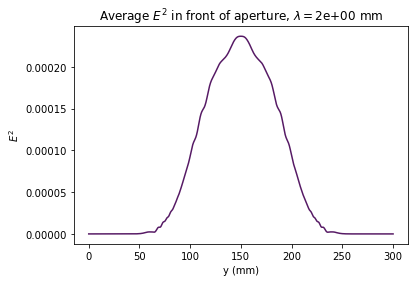

In [30]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = 7, dpml = 1)
sim2 = Sim(opt_sys)
analysis2 = Analysis(sim2)
analysis2.image_plane_beams(wavelength = 2, fwidth = 0.1, sourcetype='Gaussian beam multichromatic',
                                y_max = 100, Nb_sources = 1, sim_resolution = 7)

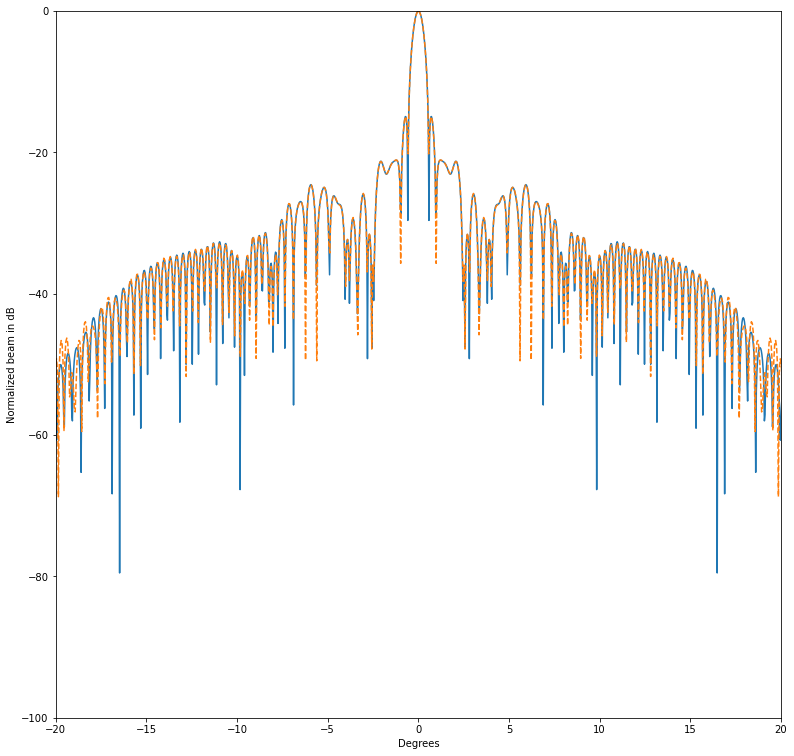

In [37]:
freq2, fft2 = analysis2.beam_FT(aperture_size = 200, precision_factor =5)
degrees2 = freq2*360
fft_dB2 = 10*np.log10(np.abs(fft2[0].real))
plt.figure(figsize = (13,13))
plt.plot(degrees, fft_dB)
plt.plot(degrees2, fft_dB2, linestyle = '--')
plt.ylim((-100, 0))
plt.xlim((-20,20))
plt.xlabel('Degrees')
plt.ylabel('Normalized beam in dB')
plt.savefig('Analysis_check')
plt.show()

The analysis in the meep_optics.py code works as expected ! 

Checking for a wavelength of 10 mm

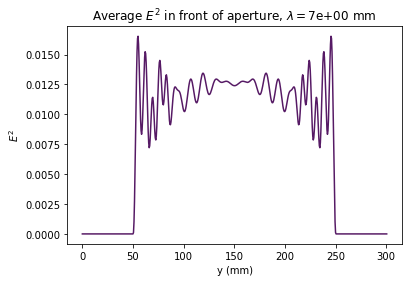

In [38]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = 2, dpml = 5)
sim3 = Sim(opt_sys)
analysis3 = Analysis(sim3)
analysis3.image_plane_beams(wavelength = 7, fwidth = 0, sourcetype='Gaussian beam',
                                y_max = 100, Nb_sources = 1, sim_resolution = 2, runtime = 800)

In [39]:
E_field = analysis3.list_efields[0]
middle_idx = np.int(len(E_field)/2)
c = max(E_field[middle_idx-5*7: middle_idx+5*7]) 

j = middle_idx
while E_field[j]>c/2 : 
    j+=1
FWHM_ap = (j-middle_idx)*2/7
if np.max(E_field)>c :
                FWHM_ap = 0
print(FWHM_ap)

0


The gaussian is truncated, we therefore expect the beam to be different (not a FWHM of lambda/D)

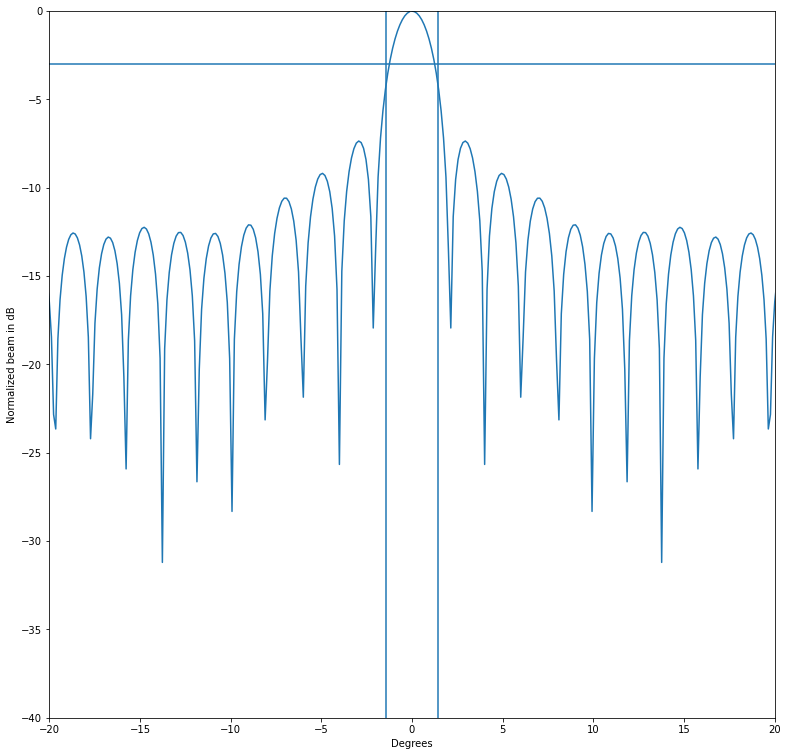

In [41]:
freq3, fft3 = analysis3.beam_FT(aperture_size = 200, precision_factor = 15)
degrees3 = np.arctan(freq3*7)*180/np.pi
fft_dB3 = 10*np.log10(np.abs(fft3[0].real))
plt.figure(figsize = (13,13))
plt.plot(degrees3, fft_dB3)
plt.ylim((-40, 0))
plt.xlim((-20,20))
plt.axhline(-3, -20, 20)
plt.vlines([-1.43,1.43], -100, 0)
plt.xlabel('Degrees')
plt.ylabel('Normalized beam in dB')
plt.savefig('Analysis_check')
plt.show()

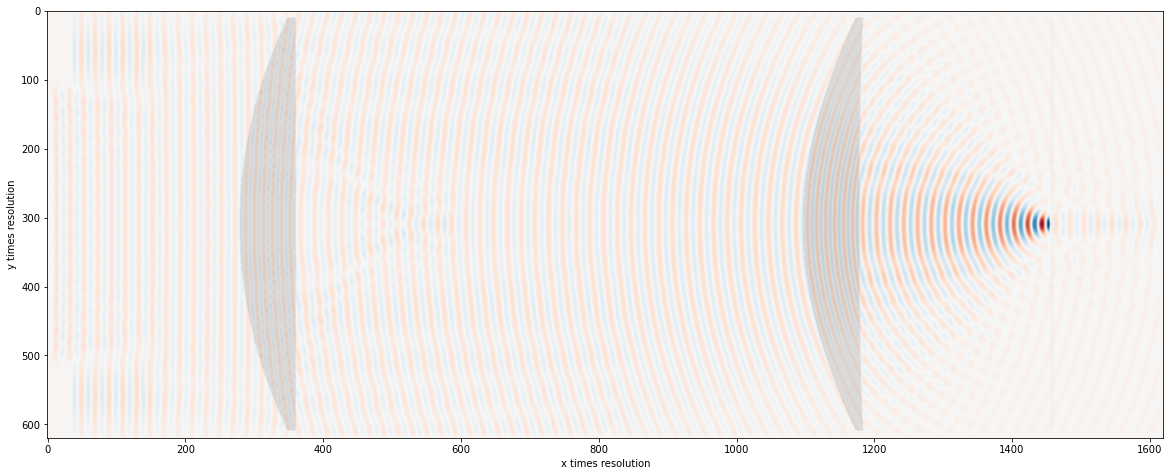

In [8]:
analysis3.sim.plot_efield()

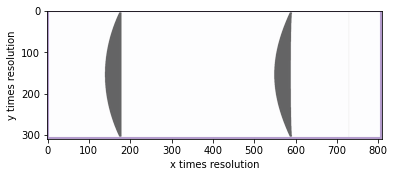

In [29]:
analysis3.sim.plot_system()

Trying for a wavelength of 1mm :

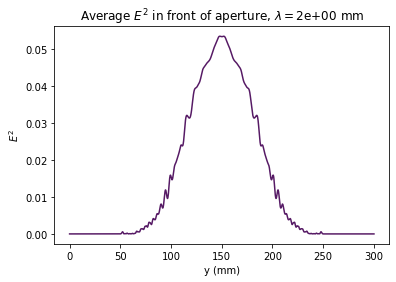

In [11]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = 7, dpml = 1)
sim4 = Sim(opt_sys)
analysis4 = Analysis(sim4)
analysis4.image_plane_beams(wavelength = 2, fwidth = 0, sourcetype='Gaussian beam',
                                y_max = 100, Nb_sources = 1, sim_resolution = 7, runtime = 800)

In [16]:
E_field = analysis4.list_efields[0]
middle_idx = np.int(len(E_field)/2)
c = max(E_field[middle_idx-5*7: middle_idx+5*7]) 

j = middle_idx
while E_field[j]>c/2 : 
    j+=1
FWHM_ap = (j-middle_idx)*2/7
if np.max(E_field)>c :
                FWHM_ap = 0
print(FWHM_ap)

74.28571428571429


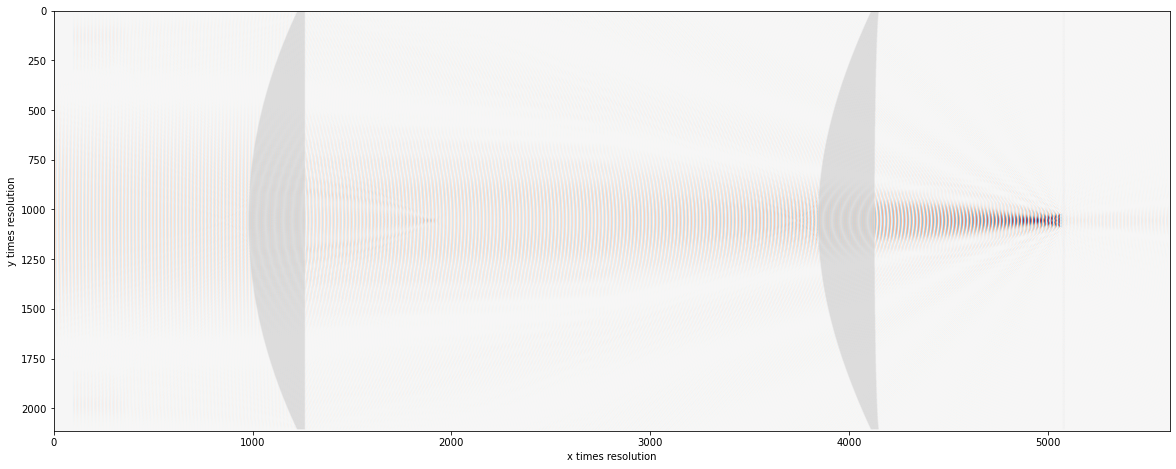

In [17]:
analysis4.sim.plot_efield()

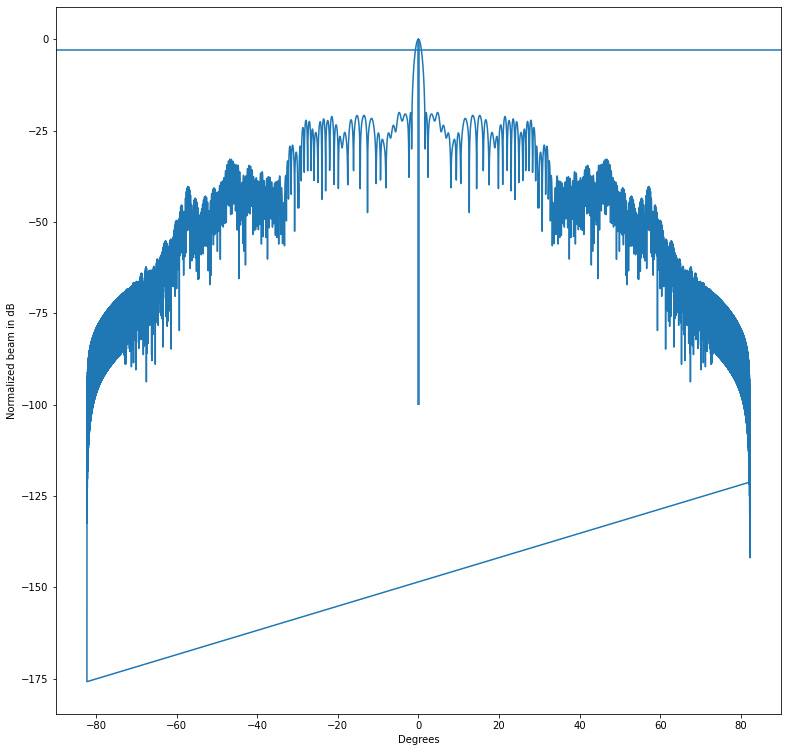

In [34]:
freq4, fft4 = analysis4.beam_FT(aperture_size = 200, precision_factor = 15)
degrees4 = np.arctan(freq4*2)*180/np.pi
fft_dB4 = 10*np.log10(np.abs(fft4[0].real))
plt.figure(figsize = (13,13))
plt.plot(degrees4, fft_dB4)
#plt.ylim((-40, 0))
#plt.xlim((-90,90))
plt.axhline(-3, -20, 20)
plt.vlines([-0.143,0.143], -100, 0)
plt.xlabel('Degrees')
plt.ylabel('Normalized beam in dB')
plt.show()

In [19]:
import meep as mp
ez_data = analysis4.sim.sim.get_array(center=mp.Vector3(365, 0, 0), size=mp.Vector3(0, 300, 0), component=mp.Ez)

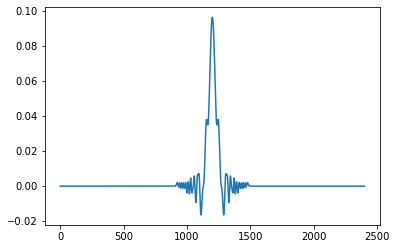

In [20]:
plt.plot(np.arange(len(ez_data)), ez_data)

# FFT tests

/home/alexei/miniconda3/envs/mp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


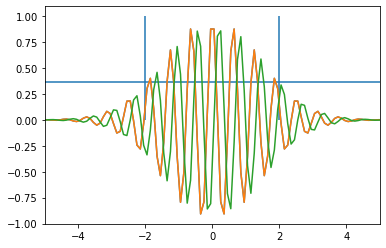

In [69]:
x = np.linspace(-50,50, 1000)
sigma = 2
s = np.exp(-x**2/(sigma**2))*(np.exp(1j*x*10))
s2 = np.exp(-x**2/(sigma**2))*np.cos(x*10)
plt.plot(x,s.real)
plt.plot(x, s2)

plt.vlines((-2,2), 0, 1)
plt.hlines(1-0.632, -5, 5)
plt.xlim(-5,5)
plt.show()

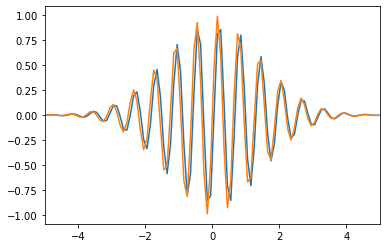

In [73]:
diff = np.diff(s.real)
diff = np.append(0, diff)
plt.plot(x, -diff)
plt.plot(x, s.imag)
plt.xlim(-5,5)
plt.show()

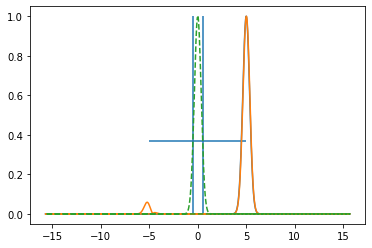

In [191]:
s_fft = np.fft.fft(s, n = 1*len(s))
s_fft2 = np.fft.fft(s2-1j*diff, n= 1*len(s))
freq = np.fft.fftfreq(1000*1, d = 0.1)*np.pi
amp = np.abs(s_fft.real)
plt.plot(freq, amp/max(amp))
plt.plot(freq, np.abs(s_fft2.real/max(s_fft2.real)))
plt.plot(freq, np.exp(-(freq*sigma)**2), linestyle = '--')
plt.vlines((-1/2,1/2), 0, 1)
plt.hlines(1-0.632, -5, 5)
#plt.xlim((-1,1))
plt.show()

/home/alexei/miniconda3/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


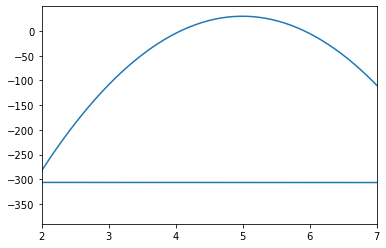

In [192]:
pouet = 10*np.log10(s_fft.real**2)
plt.plot(freq, pouet)
plt.xlim((2,7))
plt.show()